In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

## Reading in the CSV files from each Channel

In [7]:
#Here you will need to put the directory to where the CSV files are located
#This creates a dataframe for each channel
ch0_df = pd.read_csv('C:/Users/higgi/Desktop/Bismuth-data/CH0@DT5725_1146_Data_BiTest-03.csv',sep=';')
ch1_df = pd.read_csv('C:/Users/higgi/Desktop/Bismuth-data/CH1@DT5725_1146_Data_BiTest-03.csv',sep=';')
ch2_df = pd.read_csv('C:/Users/higgi/Desktop/Bismuth-data/CH2@DT5725_1146_Data_BiTest-03.csv',sep=';')

In [70]:
#Example of what the dataframe looks like
ch0_df

,TIMETAG,ENERGY,ENERGYSHORT,FLAGS
0,349009575,156,147,0x4400
1,7081197522,157,147,0x4400
2,7582042501,152,139,0x4400
3,16346724363,145,140,0x4400
4,16660847771,150,135,0x4400
...,...,...,...,...
6537,23535427962880,152,138,0x4400
6538,23537311301364,158,149,0x4400
6539,23538305984502,145,140,0x4400
6540,23538421141340,157,150,0x4400


## Process of Splitting Data into indivdual runs

In [236]:
def Split_Data(ch0_dataFrame,ch1_dataFrame,ch2_dataFrame,minimum_counts = 8000):
    
    #initializing an empty list for each channel(coincidencedata ch0, energydata ch1 ) I want to split into runs triggered
    #by the clock from ch2
    ch0split_data = []
    ch1split_data = []
    
    #iterating through the number of times ch2 recieved a signal from our clock
    for i in np.arange(0,len(ch2_dataFrame)-1):
        
        #creating a mask to separate the full data into their individual runs for ch0
        ch0time_mask = np.where((ch0_dataFrame['TIMETAG'] >= ch2_dataFrame['TIMETAG'][i]) & 
                                (ch0_dataFrame['TIMETAG'] < ch2_dataFrame['TIMETAG'][i+1]))
        
        
        #creating a mask to separate the full data into their individual runs for ch2
        ch1time_mask = np.where((ch1_dataFrame['TIMETAG'] >= ch2_dataFrame['TIMETAG'][i]) & 
                                (ch1_dataFrame['TIMETAG'] < ch2_dataFrame['TIMETAG'][i+1]))
        
        #This number for minimum counts is to remove any possible signals that may occur when we are not running but still collecting data
        if len(time_mask[0]) > minimum_counts:
            
            #for each run I am creating a new dataframe and storing in a list
            split_dataFrame0 = ch0_dataFrame.iloc[[ch0time_mask][0][0]].copy()
            #resetting the index
            split_dataFrame0 = split_dataFrame0.reset_index(drop=True)

            split_dataFrame1 = ch1_dataFrame.iloc[[ch1time_mask][0][0]].copy()
            #resetting the index
            split_dataFrame1 = split_dataFrame1.reset_index(drop=True)
            
            ch0split_data.extend([split_dataFrame0])
            ch1split_data.extend([split_dataFrame1])
    #returns two arrays of dataframes, one for channel0 and another channel1        
    return ch0split_data, ch1split_data


In [237]:
#initializing the arrays of run data
list_coincidences,list_energy = Split_Data(ch0_df,ch1_df,ch2_df)

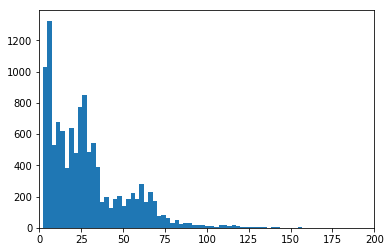

In [162]:
#looking at the 16th single second run recorded during the bismuth test
plt.hist(list_energy[15]['ENERGY'],bins=500);
plt.xlim(0,200);

In [240]:
#Looking at the coincidence data from the first 1 second run from the bismuth
list_coincidences[0]

,TIMETAG,ENERGY,ENERGYSHORT,FLAGS
0,1079562053946,153,143,0x4400
1,1083456656831,150,146,0x4400
2,1083724320852,151,146,0x4400
3,1099187385090,161,155,0x4400
4,1099979905106,161,155,0x4400
...,...,...,...,...
322,2234190169960,154,143,0x4400
323,2236385121371,157,149,0x4400
324,2243232001036,161,155,0x4400
325,2250547776248,144,140,0x4400


## Making a function for matching Coincidence data to energy data

In [363]:
def Energy_Cuts(listofcoincidences,listofenergy,delay=1000000):
    #initializing an empty list for the coincidence energies from channel 1
    coincident_energy = []
    
    #iterating through the number of runs our data was split into
    for i in np.arange(len(listofcoincidences)):
        
        #creating a buffer data frame to fill with the ch1 counts found to be coincident with ch0
        bufferpd = pd.DataFrame(columns = list_energy[0].columns)
        
        #iterating through the times in ch0 that we want to match an energy measurement from ch1 to
        for j in np.arange(len(listofcoincidences[i])):
            
            #creating a mask to look for a single value in the ch1 data that is within a certain delay time away from the ch0 detection time
            coincident_energy_mask = np.where((list_energy[i]['TIMETAG'] < list_coincidences[i]['TIMETAG'][j]) & 
                                              (list_energy[i]['TIMETAG'] > list_coincidences[i]['TIMETAG'][j]-delay))
            
            #single row of a dataframe to be appended to bufferpd
            info_on_coincident_energy = listofenergy[i].iloc[[coincident_energy_mask][0][0]]
            
            #appending the row of the data frame
            bufferpd = bufferpd.append(info_on_coincident_energy, ignore_index = True)
            
            #giving each column the correct dtype
            bufferpd = bufferpd.astype({"TIMETAG": np.int64, "ENERGY": np.int64, "ENERGYSHORT":np.int64, "FLAGS":object}) 
        
        #adding the data frame of coincident ch1 data for each run
        coincident_energy.extend([bufferpd])
    #returning a list with a length equal to the number of runs the data was split into. Each element is a dataframe for coincidences on ch1 triggered by ch0     
    return coincident_energy

In [364]:
#looking at the energy that is coincident with ch0
test = Energy_Cuts(list_coincidences,list_energy)

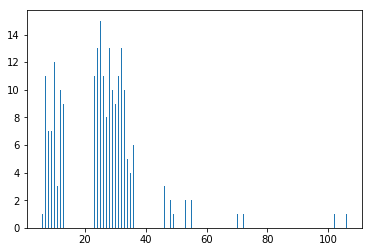

In [368]:
#plotting said energies
plt.hist(test[0]['ENERGY'],bins=500);

(array([ 8.,  4., 12.,  6., 11.,  8.,  8.,  9.,  7.,  9., 10., 10., 15.,
        14.,  8.,  9.,  7.,  7.,  5.,  7.]),
 array([1.08372432e+12, 1.14169970e+12, 1.19967509e+12, 1.25765047e+12,
        1.31562586e+12, 1.37360124e+12, 1.43157662e+12, 1.48955201e+12,
        1.54752739e+12, 1.60550278e+12, 1.66347816e+12, 1.72145354e+12,
        1.77942893e+12, 1.83740431e+12, 1.89537970e+12, 1.95335508e+12,
        2.01133046e+12, 2.06930585e+12, 2.12728123e+12, 2.18525662e+12,
        2.24323200e+12]),
 <a list of 20 Patch objects>)

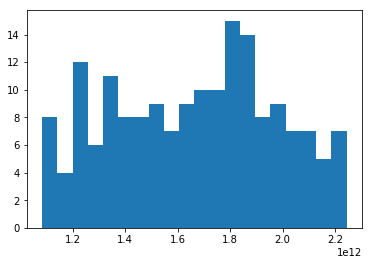

In [394]:
#This mask format allows us to find the times where energy is within a certain range and relate it directly to our ch0 counts

mask = np.where((test[0]['ENERGY'] < 40) & (test[0]['ENERGY'] > 20))

#It doesnt mean much for the bismuth since it has a close to constant counts/time at small scales, but this is a histogram of
#the counts in about every 20th of a second with the above energy constraint

plt.hist(list_coincidences[0]['TIMETAG'].iloc[[mask][0][0]],bins = 20)